In [2]:
import pandas as pd
import geopandas as gpd
import fiona; help(fiona.open)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

C:\Users\evand\AppData\Local\Temp\ipykernel_3292\2776489115.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


Help on function open in module fiona:

open(fp, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None, **kwargs)
    Open a collection for read, append, or write
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings like
    
      {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'W

In [4]:
#Load data to aggregate
df = gpd.read_file("data/properties_distance_final.gpkg", layer = "properties_distance_final")

In [3]:
colonias_gdf = gpd.read_file("data/colonias.geojson", layer='colonias')
colonias_gdf["id"]  = colonias_gdf.index
colonias_gdf.to_crs(6362, inplace = True)
colonias_gdf

,nombre,ayocon_rem_pro,vcatas_pro,vconst_pro,vsuelo_pro,geometry,id
0,Pbo. SANTIAGO TEPALCATLALPAN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((2800378.097 808491.958, 280039...",0
1,ZONA RUSTICA,1980.0,3311414.0,929524.0,2381890.0,"MULTIPOLYGON (((2804699.888 802390.165, 280470...",1
2,ZONA RUSTICA,1980.0,3311414.0,929524.0,2381890.0,"MULTIPOLYGON (((2814190.199 803430.671, 281421...",2
3,ROMULO SANCHEZ MIRELES,1985.0,967848.0,732369.0,235478.0,"MULTIPOLYGON (((2795975.832 814188.695, 279597...",3
4,CAMPO DE TIRO LOS GAMITOS,1986.0,1043647.0,830541.0,213107.0,"MULTIPOLYGON (((2789264.123 823095.611, 278926...",4
...,...,...,...,...,...,...,...
1562,JARDINES DE COYOACAN,1985.0,2315267.0,1416045.0,899222.0,"MULTIPOLYGON (((2800691.441 815947.949, 280075...",1562
1563,FUENTES BROTANTES,1988.0,735545.0,398487.0,337058.0,"MULTIPOLYGON (((2794204.043 812033.062, 279422...",1563
1564,ZONA RUSTICA,1980.0,3311414.0,929524.0,2381890.0,"MULTIPOLYGON (((2782382.857 804523.930, 278242...",1564
1565,PUEBLO SAN LORENZO TEZONCO,1956.0,5500639.0,2902492.0,2598147.0,"MULTIPOLYGON (((2807054.584 816068.661, 280705...",1565


In [4]:
join_df = df.sjoin(colonias_gdf, how="inner")
join_df

,id_left,bedrooms,bathrooms,half_bathrooms,lot_size,construction_size,age,property_type_id_id,real_age,latitude,longitude,postal_code,settlement,price,balcony,water strorage,air_conditioning,pool,furniture,accasible_for_handicap,first_floor,security,parking_space,kitchen,garden,roof_Garden,service_room,gated_community,price_per_area,price_small,price_per_area_small,high_impact/area,low_impact/area,parks,schools,university,hospital,sport_facility,supermarket,mall,stadium,historic,museum,airport,industry,subway,bus,geometry,index_right,nombre,ayocon_rem_pro,vcatas_pro,vconst_pro,vsuelo_pro,id_right
0,26054,3.0,2.0,0.0,166.0,166.0,2,3.0,2,19.401676,-99.141939,03400,álamos,5700000.0,False,False,False,False,False,False,False,True,False,False,True,False,True,False,34337.349398,5.7000,0.034337,72.810544,299.379202,1748.073994,269.173155,4428.499666,635.629511,3070.294673,650.886598,1289.354465,2742.044739,1815.041788,1528.727930,6329.453644,2201.328124,632.056443,1513.890366,POINT (2799316.460 825626.670),350,ALAMOS,1991.0,1320808.0,856565.0,464243.0,350
105,32419,2.0,2.0,0.0,78.0,78.0,0,1.0,0,19.395339,-99.142944,03400,álamos,3330500.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,42698.717949,3.3305,0.042699,72.810544,299.379202,2116.413742,362.767295,4558.128270,686.671856,2470.336237,1095.491465,1439.812482,3366.799349,2456.514458,2214.653492,6733.425575,2444.481369,510.259559,1266.116062,POINT (2799225.133 824925.241),350,ALAMOS,1991.0,1320808.0,856565.0,464243.0,350
132,37749,2.0,1.0,0.0,57.0,57.0,16,1.0,16,19.402344,-99.138770,03400,álamos,2230000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,39122.807018,2.2300,0.039123,72.810544,299.379202,2010.136070,181.328932,4733.510188,419.201978,3046.345367,517.779090,1615.732898,2821.984176,1893.628079,1542.704867,5996.243347,1866.758344,776.139506,1847.140163,POINT (2799646.826 825707.005),350,ALAMOS,1991.0,1320808.0,856565.0,464243.0,350
369,9573,3.0,1.0,0.0,102.0,102.0,33,1.0,33,19.398458,-99.140765,03400,álamos,3800000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,37254.901961,3.8000,0.037255,72.810544,299.379202,2048.752771,197.107772,4647.814161,732.101479,2694.444532,958.823894,1486.885202,3117.269483,2190.793995,1899.471451,6370.524195,2128.634771,447.613388,1520.774014,POINT (2799446.474 825273.994),350,ALAMOS,1991.0,1320808.0,856565.0,464243.0,350
603,6577,2.0,2.0,0.0,123.0,123.0,1,1.0,1,19.394143,-99.142557,03400,álamos,3906000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,31756.097561,3.9060,0.031756,72.810544,299.379202,2242.922006,498.035052,4649.190120,810.629012,2334.666565,1209.414877,1551.249587,3504.890317,2594.218467,2348.919489,6762.778992,2454.344976,486.998339,1318.870494,POINT (2799268.312 824794.065),350,ALAMOS,1991.0,1320808.0,856565.0,464243.0,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,618,2.0,1.0,0.0,55.0,55.0,2,1.0,2,19.356029,-99.152548,04610,xotepingo,2956100.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,53747.272727,2.9561,0.053747,34.610140,101.953968,1821.505578,131.962366,3747.057290,856.912323,1877.291076,200.399224,1765.436552,4054.948321,367.959582,411.085490,10255.993395,1014.050298,561.204728,1250.398226,POINT (2798305.585 820567.015),403,SAN DIEGO CHURUBUSCO,1982.0,20473784.0,9491817.0,10981967.0,403
11003,6718,4.0,2.0,0.0,110.0,110.0,24,1.0,24,19.488589,-99.198050,02459,tezozomoc,2700000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,24545.454545,2.7000,0.024545,65.221231,183.892056,1700.640796,244.187969,4950.312318,1003.269365,4295.518032,1507.540015,1681.446900,2588.049275,1572.838314,4257.738643,13445.542268,664.708241,318.

In [5]:
join_df[join_df["lot_size"]<0]

,id_left,bedrooms,bathrooms,half_bathrooms,lot_size,construction_size,age,property_type_id_id,real_age,latitude,longitude,postal_code,settlement,price,balcony,water strorage,air_conditioning,pool,furniture,accasible_for_handicap,first_floor,security,parking_space,kitchen,garden,roof_Garden,service_room,gated_community,price_per_area,price_small,price_per_area_small,high_impact/area,low_impact/area,parks,schools,university,hospital,sport_facility,supermarket,mall,stadium,historic,museum,airport,industry,subway,bus,geometry,index_right,nombre,ayocon_rem_pro,vcatas_pro,vconst_pro,vsuelo_pro,id_right


In [6]:
#pd.set_option('display.max_rows', None)
join_df.groupby("id_right").size().reset_index().sort_values(by=0).reset_index()

,index,id_right,0
0,0,8,1
1,509,1050,1
2,176,356,1
3,508,1049,1
4,503,1042,1
...,...,...,...
696,301,648,228
697,234,480,256
698,175,355,269
699,180,362,274


In [7]:
col_list = join_df.columns[:31].to_list()
col_list.append("id_right")
join_df_1 = join_df[col_list]
join_df_1 = join_df_1.groupby("id_right").mean(numeric_only = True).reset_index()

In [8]:
col_list = join_df.columns[31:].to_list()

join_df_2 = join_df[col_list]
join_df_2 = join_df_2.groupby("id_right").median(numeric_only = True).reset_index()


In [15]:
neighborhood_df = pd.concat([join_df_1,join_df_2.drop("id_right",axis = 1)] ,axis = 1)

#Merge to get geometry of neighborhood
neighborhood_df = pd.merge(neighborhood_df,colonias_gdf, how = "inner", left_on = "id_right", right_on = "id")

neighborhood_df.drop(["index_right","id","id_left","nombre","vcatas_pro_x","vconst_pro_x" ,"vsuelo_pro_x", "ayocon_rem_pro_y","vcatas_pro_y", "vconst_pro_y", "ayocon_rem_pro_x", "vsuelo_pro_y"], axis = 1, inplace = True)

# #Normalize data
# to_norm = neighborhood_df.drop(["geometry","id_right"], axis = 1)

# #Normalizing min max
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# neighborhood = min_max_scaler.fit_transform(to_norm)
# neighborhood = pd.DataFrame(neighborhood, columns = to_norm.columns)

# #Adding geom
# neighborhood_df_norm = pd.concat([neighborhood,neighborhood_df[["geometry","id_right"]]] ,axis = 1)
neighborhood_df['price'] = neighborhood_df["price"]/1000000

neighborhood_gpd = gpd.GeoDataFrame(neighborhood_df)
neighborhood_gpd = neighborhood_gpd[neighborhood_gpd["lot_size"] < 2500]
#neighborhood_gpd.geometry = neighborhood_gpd.geometry.centroid 
neighborhood_gpd.to_csv("data/nb_df_non_norm.csv")
neighborhood_gpd.to_file("data/nb_df_non_norm.gpkg", driver = "GPKG", geometry = "geometry")
neighborhood_gpd.explore()
neighborhood_gpd

,id_right,bedrooms,bathrooms,half_bathrooms,lot_size,construction_size,age,property_type_id_id,real_age,latitude,longitude,price,balcony,water strorage,air_conditioning,pool,furniture,accasible_for_handicap,first_floor,security,parking_space,kitchen,garden,roof_Garden,service_room,gated_community,price_per_area,price_small,price_per_area_small,high_impact/area,low_impact/area,parks,schools,university,hospital,sport_facility,supermarket,mall,stadium,historic,museum,airport,industry,subway,bus,geometry
0,8,5.000000,6.000000,0.000000,127.000000,326.0,51.0,3.000000,51.0,19.464320,-99.195730,3.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,26771.653543,3.400000,0.026772,28.581121,97.512059,586.720769,465.974064,3127.460459,1196.428110,1607.064802,456.769413,1193.359965,4257.097034,1740.157222,2277.825092,12235.970324,1492.040868,1684.344089,1019.752879,"MULTIPOLYGON (((2793299.849 832180.730, 279330..."
1,16,2.000000,1.000000,0.000000,51.500000,51.5,16.5,1.000000,16.5,19.445166,-99.186827,2.539500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,49082.765152,2.539500,0.049083,99.751498,333.315982,156.065404,625.040571,2128.119358,1093.080949,889.039198,387.607969,591.268989,4293.090727,1440.295797,1665.448164,10737.018167,455.480428,489.378170,658.427452,"MULTIPOLYGON (((2794357.004 830240.705, 279438..."
2,33,1.000000,1.000000,0.000000,75.000000,75.0,1.0,1.000000,1.0,19.423254,-99.202597,6.950000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,92666.666667,6.950000,0.092667,44.170873,302.885989,1911.896141,1150.971319,2422.712911,323.641604,2288.716657,231.353736,1337.025120,5029.492519,644.118349,966.846435,12149.561949,2434.973811,1035.610083,1800.881957,"MULTIPOLYGON (((2792835.890 828193.326, 279284..."
3,34,10.000000,4.000000,0.000000,146.000000,394.0,1.0,3.000000,1.0,19.413246,-99.123804,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,47945.205479,7.000000,0.047945,34.594084,191.839920,925.197049,272.198915,6185.724992,1094.884601,4255.392977,416.033963,968.789002,3211.459710,1283.399152,1968.043760,4097.478728,596.458392,755.875029,1102.914319,"MULTIPOLYGON (((2801132.447 826978.129, 280115..."
4,35,3.000000,2.000000,0.000000,128.000000,118.0,25.0,3.000000,25.0,19.446481,-99.198668,4.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,33203.125000,4.250000,0.033203,100.115992,300.347975,1110.729010,620.699676,3296.101243,668.416698,647.301662,611.165077,758.568536,5447.071053,1195.717754,847.485780,11979.866970,1131.597411,703.023606,820.322912,"MULTIPOLYGON (((2793254.156 830422.310, 279325..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,1559,3.000000,2.800000,1.200000,548.600000,349.8,14.4,3.000000,14.4,19.246327,-99.161323,5.742400,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.0,0.4,0.2,0.0,12807.765605,5.742400,0.012808,4.572922,19.954567,4227.027142,765.394029,4161.946486,802.147847,8007.182423,926.165170,4050.488791,1640.580328,2991.383276,4194.409443,20961.078611,5062.719391,5956.882503,886.012422,"MULTIPOLYGON (((2796977.276 808648.302, 279697..."
697,1561,3.000000,3.000000,1.000000,170.500000,224.5,5.0,3.000000,5.0,19.316100,-99.130516,8.500000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,49680.814355,8.500000,0.049681,22.680586,78.188337,996.414619,396.511065,1012.903147,742.050806,6560.246266,487.324918,625.607088,2552.499479,1008.083754,1591.025134,12841.528387,892.442021,889.786351,1123.791936,"MULTIPOLYGON (((2800395.769 816279.216, 280039..."
698,1562,4.000000,3.000000,1.000000,200.000000,300.0,27.0,3.000000,27.0,19.313126,-99.125739,7.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,38500.000000,7.700000,0.038500,20.305429,138.689910,514.933103,689.866283,1379.643477,480.633333,6916.088829,303.524405,431.3

In [17]:
import matplotlib.pyplot as plt

(array([ 6., 35., 58., 83., 74., 70., 49., 42., 43., 40., 39., 28., 23.,
        17., 14., 12.,  4.,  9.,  7.,  6.,  5.,  5.,  4.,  3.,  2.,  2.,
         1.,  4.,  1.,  1.,  3.,  3.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.5355 ,  1.16459,  1.79368,  2.42277,  3.05186,  3.68095,
         4.31004,  4.93913,  5.56822,  6.19731,  6.8264 ,  7.45549,
         8.08458,  8.71367,  9.34276,  9.97185, 10.60094, 11.23003,
        11.85912, 12.48821, 13.1173 , 13.74639, 14.37548, 15.00457,
        15.63366, 16.26275, 16.89184, 17.52093, 18.15002, 18.77911,
        19.4082 , 20.03729, 20.66638, 21.29547, 21.92456, 22.55365,
        23.18274, 23.81183, 24.44092, 25.07001, 25.6991 , 26.32819,
        26.95728, 27.58637, 28.21546, 28.84455, 29.47364, 30.10273,
        30.73182, 31.36091, 31.99   ]),
 <BarContainer object of 50 artists>)

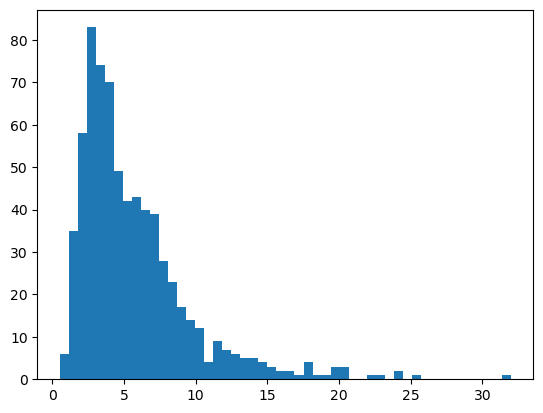

In [18]:
plt.hist(neighborhood_gpd["price"], bins = 50)